# Generating confusion matrix for DPA
Section 4.1 in the paper

## Goal
Generate the confusion matrix $\mathbf{K}$ for DPA and from the extract the main diagonal as the confusion vector $\kappa$.

From the paper we know that the correct key for this S-Box is 60 ($k_c = 60$). We can then use the three-way confusion coefficients given by:
$$
\tilde \kappa(k_c, k_{gi}, k_{gj}) = \frac{1}{2} [ \tilde  \kappa(k_c, k_{gi}) + \tilde  \kappa(k_c, k_{gj}) - \tilde  \kappa(k_{gi}, k_{gj}) ] 
$$
$$
\tilde \kappa(k_i, k_j) = E[(V|k_i - V|k_j)^2] = Pr[(V|k_i) \neq (V|k_j)]
$$

It is worth noting that the confusion matrix $\mathbf{K}$ skips over the value for $k_c$. Therefore $\mathbf{K}$ is a $63 \times 63$ matrix.

In [62]:
from des_helpers import dpa_select_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [63]:
# Load the arrays using pickle
def load_confusion_data_pickle(input_path="confusion_Kc.pkl"):
	with open(input_path, "rb") as f:
		data = pickle.load(f)
	print(f"Confusion data loaded from {input_path}")
	return data

# Save the arrays using pickle
def save_confusion_data_pickle(K, output_path="confusion_Kc.pkl"):
	with open(output_path, "wb") as f:
		pickle.dump(K, f)
	print(f"Confusion data saved to {output_path}")

In [ ]:
# Load data
from analysis_functions import des_sbox_output, DES_Sboxes
trace_df = pd.read_csv("des_extension_data.csv")

# Constants
NUM_KEYS = 64  # Keys range from 0 to 63
kc = 4  # Known correct key index
# plaintexts = trace_df['Plaintext']
plaintexts = range(64)

V_map = {}

# Precomputing values from the select function for all possible keys
for i in range(NUM_KEYS):
	# V_map[i] = np.array([dpa_select_function(pt.upper(), i) for pt in plaintexts])
	V_map[i] = np.array([
		int(des_sbox_output(
			int(format(pt, '06b'), 2) ^ int(format(i, '06b'), 2), 
			DES_Sboxes[0]
		)[0])
		for pt in plaintexts
	])

# Compute confusion coefficients k, K, and K*
def compute_confusion_coefficients(kc):
	# Initialize confusion vector and matrices
	K = np.zeros((NUM_KEYS-1, NUM_KEYS-1))  # Confusion matrix K
	K_star = np.zeros((NUM_KEYS-1, NUM_KEYS-1))  # Confusion matrix K
	
	# Compute V|kc
	V_kc = V_map[kc]
	
	for kgi in range(NUM_KEYS):  # Iterate over candidate keys kgi
		V_kgi = V_map[kgi]
		if kgi == kc:
			continue

		for kgj in range(NUM_KEYS):  # Iterate over candidate keys kgj
			V_kgj = V_map[kgj]
			if kgj == kc:
				continue
			
			three_way_kappa = np.mean((V_kc - V_kgi) * (V_kc - V_kgj))
			three_way_kappa_star = np.mean((V_kc - V_kgi) ** 2 * (V_kc - V_kgj) ** 2)

			i = kgi if kgi < kc else kgi-1
			j = kgj if kgj < kc else kgj-1
			
			K[i, j] = three_way_kappa  # K(kc, kgi, kgj)
			K_star[i, j] = three_way_kappa_star  # K(kc, kgi, kgj)
	
	return K, K_star

# Compute confusion coefficients
K, K_star = compute_confusion_coefficients(kc)

# Save the computed data
save_confusion_data_pickle(K, f"confusion_Kc={kc}.pkl")
save_confusion_data_pickle(K_star, f"confusion_Kc_star={kc}.pkl")

Confusion data saved to confusion_Kc=4.pkl
Confusion data saved to confusion_Kc_star=4.pkl


Confusion data loaded from confusion_Kc=4.pkl


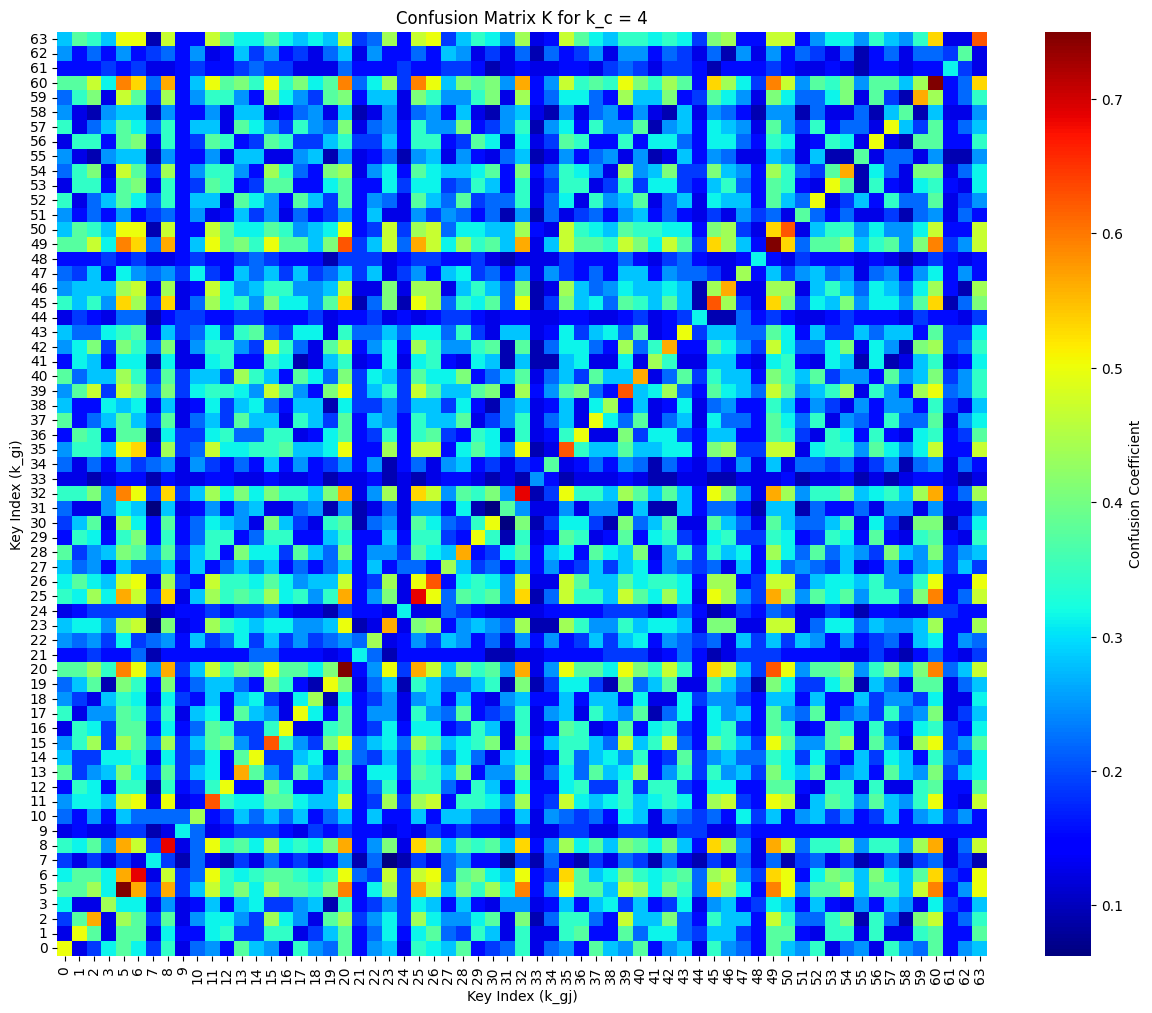

0.2579994960947342


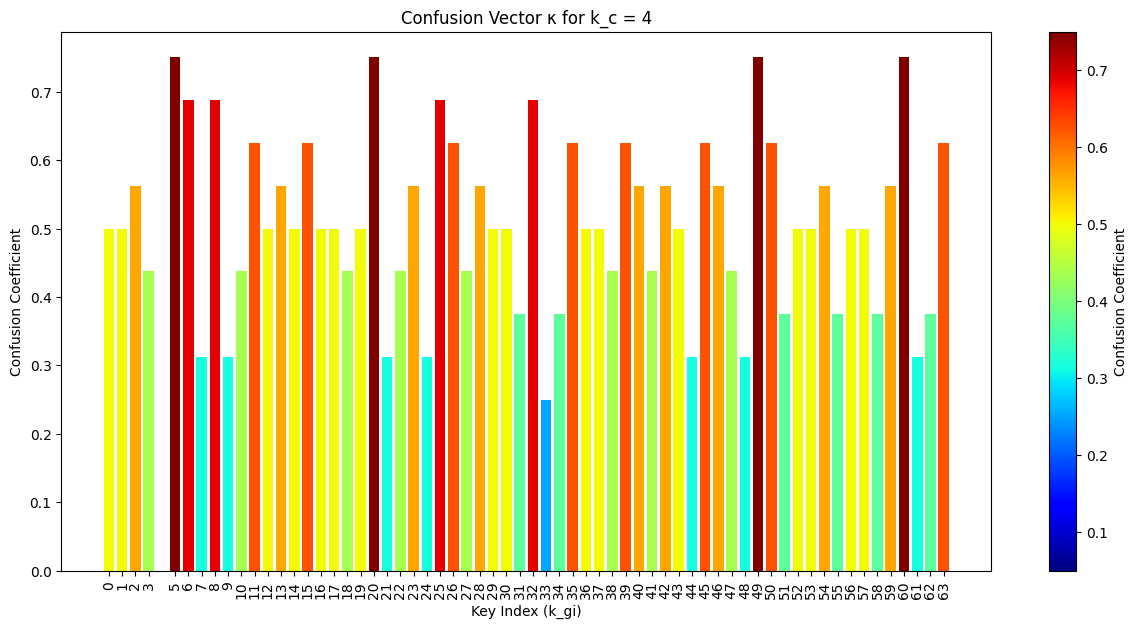

0.5079365079365079


In [70]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Load confusion matrix K
K = load_confusion_data_pickle(input_path=f"confusion_Kc={kc}.pkl")

n_keys = K.shape[0]  # Assuming K is square

# Create custom labels
true_labels = [i for i in range(NUM_KEYS) if i != kc]
tick_positions = np.arange(n_keys) + 0.5

# Visualize confusion matrix K with flipped y-axis and custom color scale
plt.figure(figsize=(15, 12))
sns.heatmap(K, annot=False, fmt=".2f", cmap="jet", cbar_kws={'label': 'Confusion Coefficient'})

# Adjust axis labels
plt.xticks(ticks=tick_positions, labels=true_labels, rotation=90)  # Adjust x-axis labels
plt.yticks(ticks=tick_positions, labels=true_labels, rotation=0)   # Adjust y-axis labels

# Title and labels
plt.title(f"Confusion Matrix K for k_c = {kc}")
plt.xlabel("Key Index (k_gj)")
plt.ylabel("Key Index (k_gi)")

# Flip y-axis
plt.gca().invert_yaxis()

plt.show()

print(np.mean(K))


# Visualize the confusion vector kappa
confusion_vector = np.diag(K)

# Normalize and apply colormap
norm = Normalize(vmin=0.05, vmax=0.75)
colormap = cm.jet
colors = colormap(norm(confusion_vector))

# Bar chart
plt.figure(figsize=(15, 7))
plt.bar(true_labels, confusion_vector, color=colors, align='center')  # Align bars at the center

# Add labels and title
plt.title(f"Confusion Vector κ for k_c = {kc}")
plt.xlabel("Key Index (k_gi)")
plt.ylabel("Confusion Coefficient")

# Add color bar
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Only for display
plt.colorbar(sm, ax=plt.gca(), label='Confusion Coefficient')

# Adjust x-axis labels for the bar graph
plt.xticks(ticks=true_labels, labels=true_labels, rotation=90)

plt.show()

print(np.mean(confusion_vector))